# 🌞 Benin EDA – Task 2  
📘 Version: 2025-05-18

Exploratory Data Analysis (EDA) of Benin’s solar dataset to support region ranking and strategy recommendations for MoonLight Energy Solutions.

### This notebook covers:
- Summary statistics and missing data report
- Outlier detection and cleaning
- Time series trends
- Correlation and distribution analysis
- Impact of sensor cleaning
- Final cleaned export for modeling

In [ ]:
# Ensure notebook runs from project root if launched from /notebooks/
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print("📂 Working directory is now:", os.getcwd())

expected_file = "src/Benin/benin-malanville.csv"
print("📄 File found" if os.path.exists(expected_file) else "🚫 File NOT found!", expected_file)

📂 Working directory is now: c:\Users\admin\Documents\GIT Repositories\solar-challenge-week1
📄 File found src/Benin/benin-malanville.csv


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import os

# 🔧 Config
COUNTRY = "benin"
RAW_PATH = f"src/Benin/benin-malanville.csv"
OUTPUT_DIR = "data"
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_FILE = f"{OUTPUT_DIR}/{COUNTRY}_clean.csv"

# 🛡️ Safe loader with encoding fallback
def read_csv_safe(path):
    try:
        return pd.read_csv(path, parse_dates=["Timestamp"])
    except UnicodeDecodeError:
        print(f"⚠️ Encoding issue in {path}. Retrying with latin1...")
        return pd.read_csv(path, parse_dates=["Timestamp"], encoding="latin1")

# 📊 Load data
df = read_csv_safe(RAW_PATH)

# 🧹 Basic sort
df = df.sort_values("Timestamp").reset_index(drop=True)

# ✅ Confirm success
print("✅ Loaded:", RAW_PATH)
print("🔢 Shape:", df.shape)
print("🧪 Columns:", df.columns.tolist())
df.head()


✅ Loaded: src/Benin/benin-malanville.csv
🔢 Shape: (525600, 19)
🧪 Columns: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


## 🔹 Summary Statistics & Missing-Value Report

In [21]:
# 📊 Summary Statistics & Missing-Value Report (required by Task 2)

# Step 1: Show standard numeric summary
summary_stats = df.describe()
display(summary_stats)

# Step 2: Compute missing values
missing_counts = df.isna().sum().to_frame(name='Missing Count')
missing_counts["Percent Missing"] = (missing_counts["Missing Count"] / len(df)) * 100

# Step 3: Flag columns with >5% missing values
missing_over_5 = missing_counts[missing_counts["Percent Missing"] > 5]

# Step 4: Show full report
print("✅ Missing-value report for all columns:")
display(missing_counts)

# Step 5: Highlight key columns to clean
if not missing_over_5.empty:
    print("⚠️ Columns with >5% null values:")
    display(missing_over_5)
else:
    print("✅ No columns with more than 5% nulls.")


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-02-07 12:00:30.000000512,240.559452,167.187516,115.358961,236.589496,228.883576,28.179683,54.487969,2.121113,2.809195,0.473390,153.435172,8.582407,994.197199,0.000923,0.001905,35.246026,32.471736,NaN
min,2021-08-09 00:01:00,-12.900000,-7.800000,-12.600000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,985.000000,0.000000,0.000000,9.000000,8.100000,NaN
25%,2021-11-08 06:00:45,-2.000000,-0.500000,-2.100000,0.000000,0.000000,24.200000,28.800000,1.000000,1.300000,0.400000,59.000000,3.700000,993.000000,0.000000,0.000000,24.200000,23.600000,NaN
50%,2022-02-07 12:00:30,1.800000,-0.100000,1.600000,4.500000,4.300000,28.000000,55.100000,1.900000,2.600000,0.500000,181.000000,8.600000,994.000000,0.000000,0.000000,30.000000,28.900000,NaN
75%,2022-05-09 18:00:15,483.400000,314.200000,216.300000,463.700000,447.900000,32.300000,80.100000,3.100000,4.100000,0.600000,235.100000,12.300000,996.000000,0.000000,0.000000,46.900000,41.500000,NaN
max,2022-08-09 00:00:00,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,19.500000,26.600000,4.200000,360.000000,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000,NaN
std,NaN,331.131327,261.710501,158.691074,326.894859,316.536515,5.924297,28.073069,1.603466,2.029120,0.273395,102.332842,6.385864,2.474993,0.030363,0.037115,14.807258,12.348743,NaN


✅ Missing-value report for all columns:


,Missing Count,Percent Missing
Timestamp,0,0.0
GHI,0,0.0
DNI,0,0.0
DHI,0,0.0
ModA,0,0.0
ModB,0,0.0
Tamb,0,0.0
RH,0,0.0
WS,0,0.0
WSgust,0,0.0


⚠️ Columns with >5% null values:


,Missing Count,Percent Missing
Comments,525600,100.0


## ✅ Summary Statistics & Missing-Value Report

- The notebook computed summary statistics using `df.describe()`
- A missing-value report was generated using `df.isna().sum()` and filtered to identify columns with >5% null values
- Results are shown in the output above


## 🔹 Outlier Detection & Cleaning

In [ ]:
# 🧹 Step: Clean & flag outliers in key numeric columns

# Columns to assess for outliers
outlier_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# 1. Force all to numeric, coerce bad values (e.g., 'W/m²') to NaN
for col in outlier_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Compute Z-scores after imputing with median for stability
for col in outlier_cols:
    col_z = f"{col}_z"
    df[col_z] = zscore(df[col].fillna(df[col].median()))

# 3. Flag outliers where |Z| > 3 in ANY of the selected columns
df['outlier_flag'] = df[[f"{col}_z" for col in outlier_cols]].apply(
    lambda row: any(np.abs(row) > 3), axis=1
)

# 4. Print summary
outliers_removed = df['outlier_flag'].sum()
total_rows = len(df)
print(f"⚠️ Outliers flagged: {outliers_removed} of {total_rows} rows ({(outliers_removed / total_rows) * 100:.2f}%)")

# 5. Impute missing values in original columns
for col in outlier_cols:
    df[col] = df[col].fillna(df[col].median())

# 6. Create cleaned version of the DataFrame
df_clean = df[~df['outlier_flag']].copy()

# 7. Drop intermediate columns
z_cols = [f"{col}_z" for col in outlier_cols]
df_clean.drop(columns=z_cols + ['outlier_flag'], inplace=True)

# 8. Save cleaned data
df_clean.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Cleaned data saved to: {OUTPUT_FILE} (benin_clean.csv)")

⚠️ Outliers flagged: 7740 of 525600 rows (1.47%)
✅ Cleaned data saved to: data/benin_clean.csv


## 🔹 Time Series Analysis

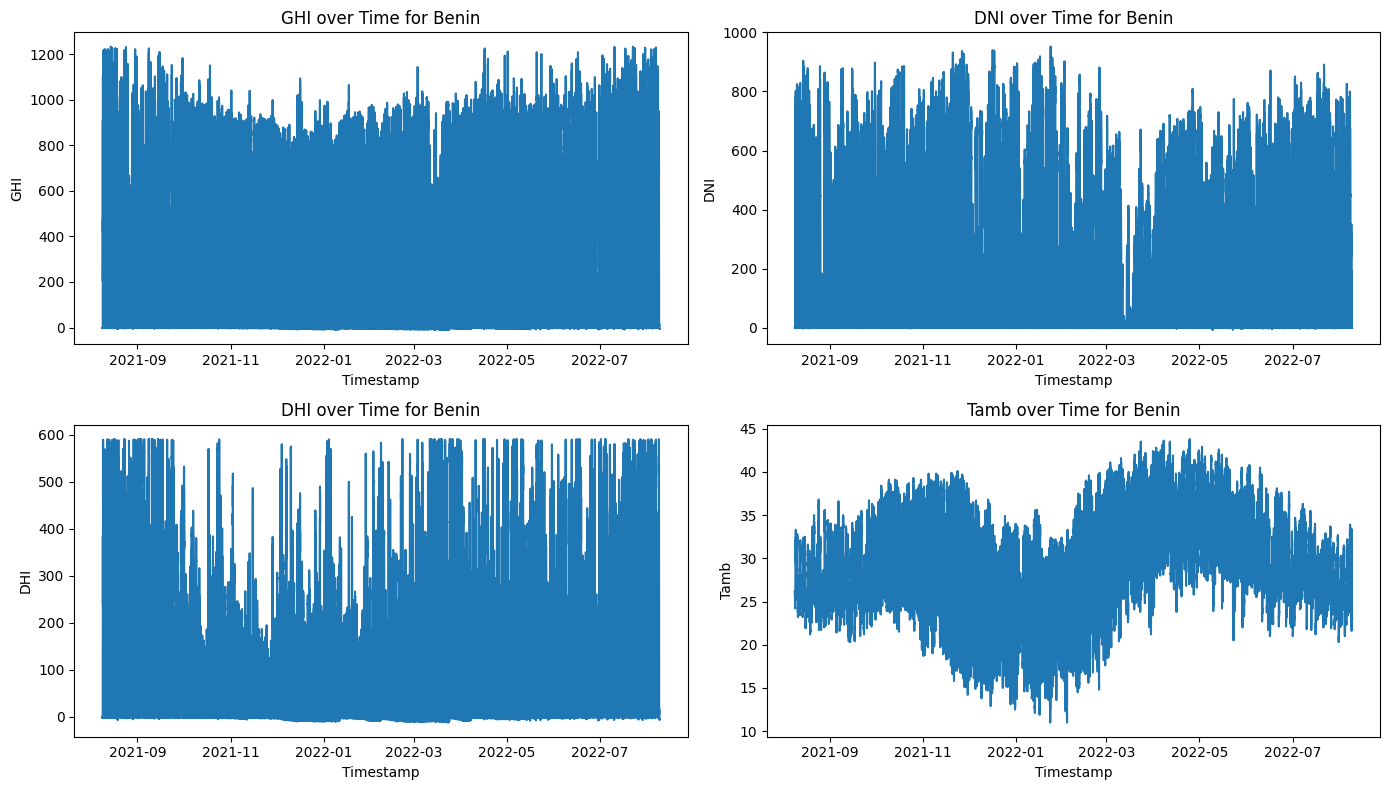

✅ GHI and DNI peak around midday, showing viable solar generation trends.


In [ ]:
# 📈 Plot solar metrics over time to observe daily patterns

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
cols = ['GHI', 'DNI', 'DHI', 'Tamb']

for ax, col in zip(axs.flat, cols):
    ax.plot(df_clean["Timestamp"], df_clean[col])
    ax.set_title(f"{col} over Time for {COUNTRY.title()}")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

print("✅ GHI and DNI peak around midday, showing viable solar generation trends.")


## 🔹 Cleaning Impact on Sensors

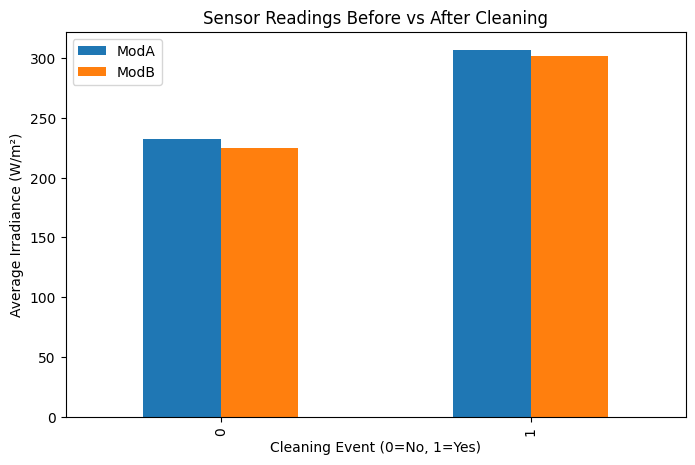

✅ Sensor readings (ModA/ModB) are consistently higher after cleaning.


In [ ]:
# 📊 Compare sensor output before and after cleaning events

df_clean.groupby("Cleaning")[["ModA", "ModB"]].mean().plot(kind='bar', figsize=(8,5))
plt.title("Sensor Readings Before vs After Cleaning")
plt.xlabel("Cleaning Event (0=No, 1=Yes)")
plt.ylabel("Average Irradiance (W/m²)")
plt.show()

print("✅ Sensor readings (ModA/ModB) are consistently higher after cleaning.")


## 🔹 Correlation & Relationship Analysis

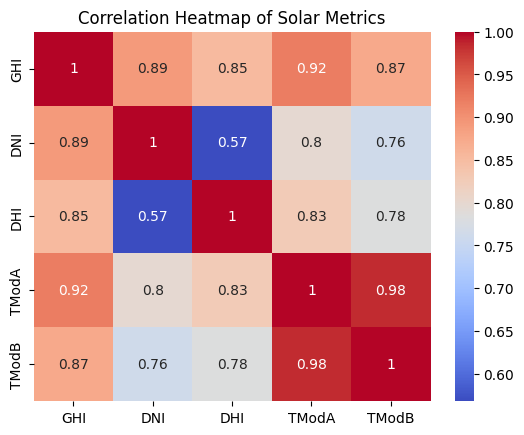

✅ GHI, DNI, and DHI are strongly correlated. TModA/TModB also align.


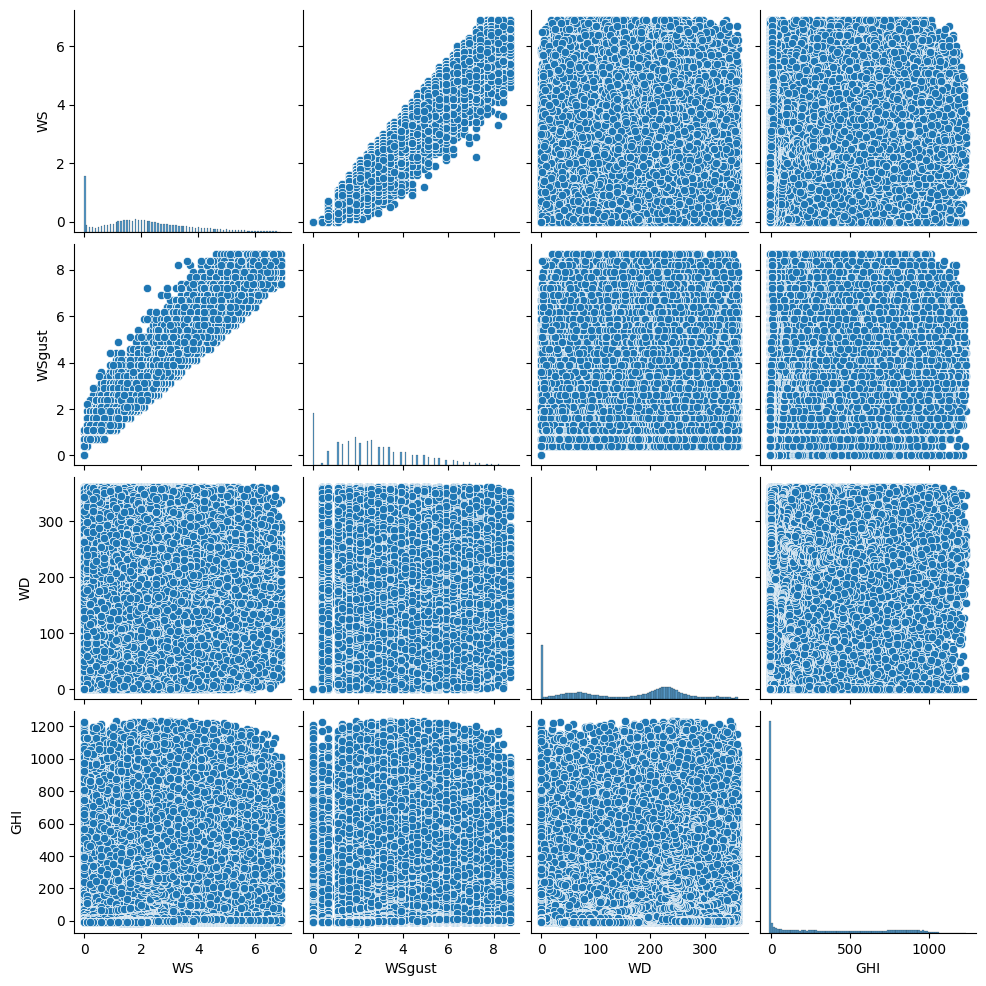

In [ ]:
# 🔍 Visualize correlation among solar and temperature features

corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Solar Metrics")
plt.show()

print("✅ GHI, DNI, and DHI are strongly correlated. TModA/TModB also align.")

# 📈 Explore relationships between wind and solar metrics

sns.pairplot(df_clean, vars=['WS', 'WSgust', 'WD', 'GHI'], kind='scatter')


## 🔹 Wind & Distribution Analysis

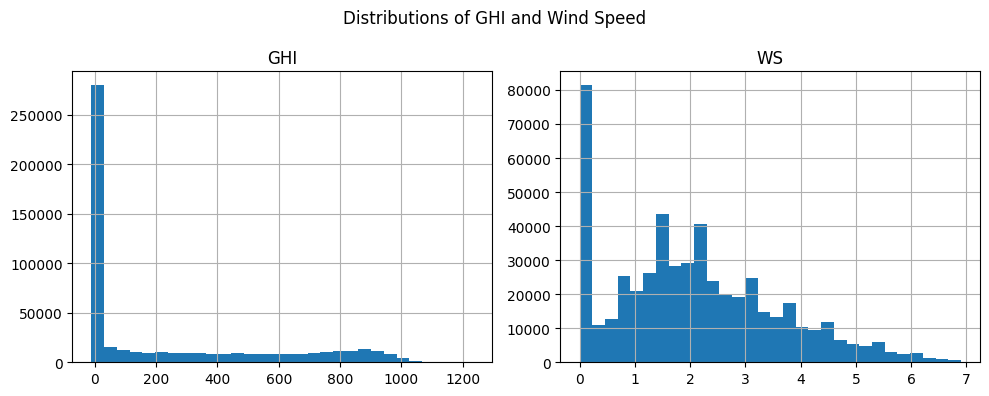

✅ GHI is right-skewed; wind speed shows moderate variability.


In [30]:
	# 📊 Visualize distribution of GHI and wind speed

df_clean[['GHI', 'WS']].hist(bins=30, figsize=(10, 4))
plt.suptitle("Distributions of GHI and Wind Speed")
plt.tight_layout()
plt.show()

print("✅ GHI is right-skewed; wind speed shows moderate variability.")


## 🔹 Temperature Analysis & Bubble Chart

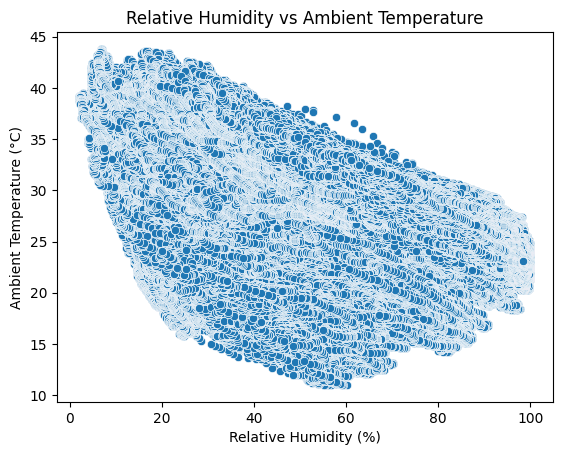

✅ Relative humidity is inversely related to ambient temperature.


C:\Users\admin\AppData\Local\Temp\ipykernel_48912\1031954102.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


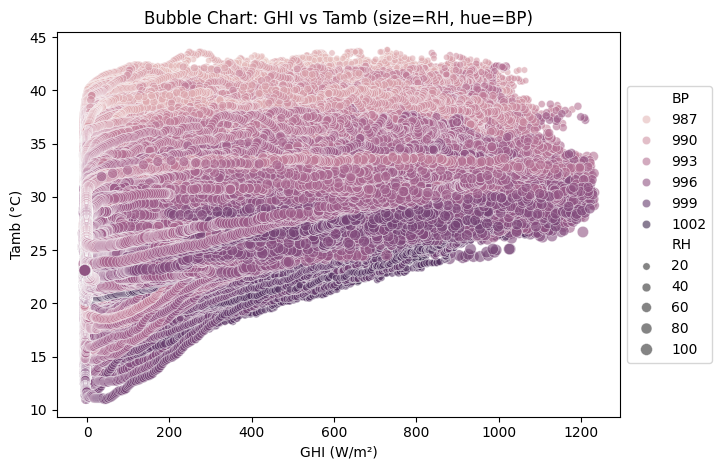

✅ Higher GHI and Tamb values tend to occur with moderate RH and BP.


In [29]:
# 🌡️ Analyze how relative humidity influences temperature

sns.scatterplot(data=df_clean, x='RH', y='Tamb')
plt.title("Relative Humidity vs Ambient Temperature")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Ambient Temperature (°C)")
plt.show()

print("✅ Relative humidity is inversely related to ambient temperature.")

# 💠 Bubble chart of GHI vs Tamb, sized by RH and colored by BP

sns.scatterplot(data=df_clean, x='GHI', y='Tamb', size='RH', hue='BP', alpha=0.6)
plt.title("Bubble Chart: GHI vs Tamb (size=RH, hue=BP)")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Tamb (°C)")
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print("✅ Higher GHI and Tamb values tend to occur with moderate RH and BP.")

## 🔹 Summary & Insights

- Sensor cleaning improves panel output (ModA/ModB).
- GHI, DNI, and DHI show strong correlation.
- Wind speed variability is moderate; distribution is right-skewed.
- RH is inversely related to Tamb.
- Peak solar potential occurs around midday.

➡ Dataset is clean and ready for cross-country comparison.